# BITSTAMP BTC/USD market

### Packages

In [1]:
# External packages
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import datetime 


# Internal packages
import sys
sys.path.append('../Code/TS_helpers/')
sys.path.append('../Code/')

data_dir = '../../Data/Coins/BTC_USD/bitcoin-historical-data/'

from dates_kaggle1min import make_all_time_indexes, make_integer_time_index
from util import print_rmse, exp_smooth
from financial_ts_visualizers import summarise_BTC1min

class Struct(object): pass




## Tsplot
import pandas as pd
import numpy as np

import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs
import statsmodels.stats as sms

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
daily = pd.read_pickle('./daily_simple_aggs.pkl')

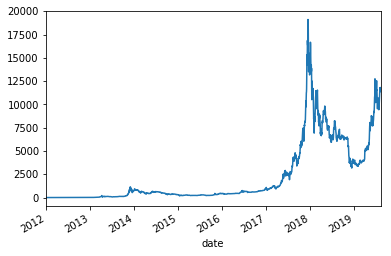

In [76]:
daily_df = pd.DataFrame({
    
    'sum_vol_cur': daily.volume_cur,
    'sum_vol_btc': daily.volume_btc,
    
    'close': daily.close,
    'open': daily.open,
    'high': daily.high, 
    'low': daily.low,
    
    'vwa_close': daily.weighted_close,
    'vwa_open': daily.weighted_open,
    'vwa_high': daily.weighted_high,
    'vwe_low': daily.weighted_low,
              
    'vwe_pr': daily.weighted_price,
    
    'lr_vwe_pr': (daily.weighted_price/daily.weighted_price.shift()).apply(np.log),
    
    
    'count_non_na_mins': daily.non_na_minute_counts
              })

daily_df['vwe_pr'].plot()

## Overview

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/base/tsa_model.py:225: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


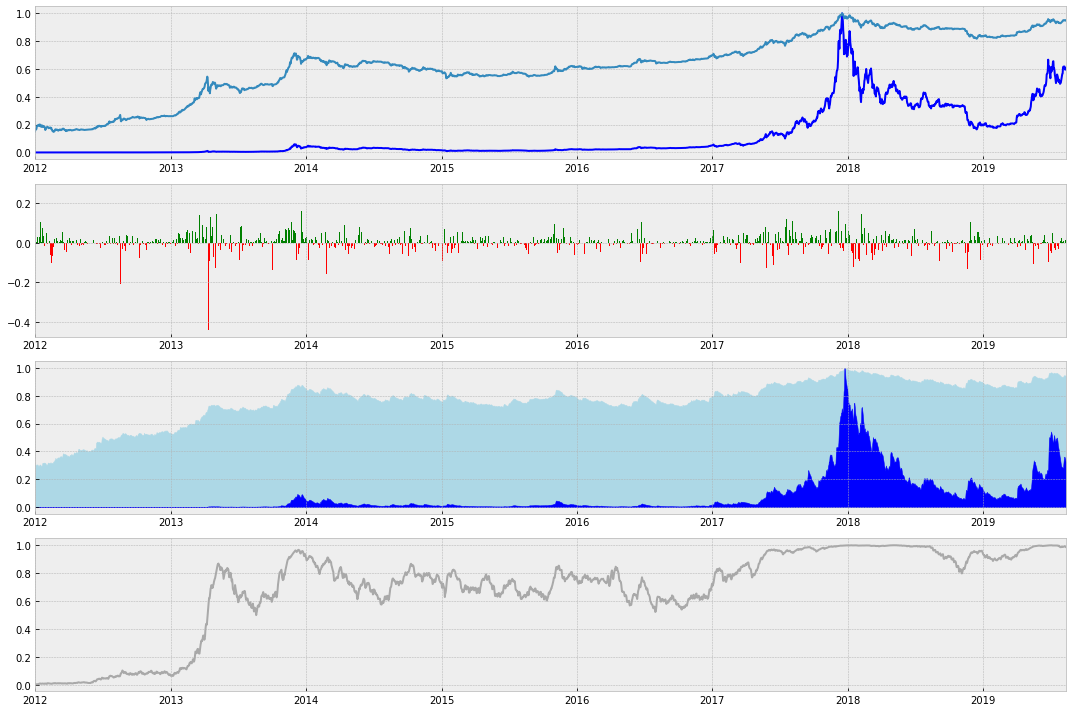

In [77]:
time_first = daily_df.index[0]
time_last = daily_df.index[-1]

summarise_BTC1min(df=daily_df, 
                  
                  col_val='vwe_pr', 
                  col_volume='sum_vol_cur',
                  
                  time_first = time_first,
                  time_last = time_last,
                  
                  cols_smooth=['sum_vol_cur', 
                               'count_non_na_mins'])

### Train test split

From the plot we make decisions for the train test validation splits

#### Masks 

In [184]:
train_first_day = pd.to_datetime('2013-01-01')
val_first_day = pd.to_datetime('2016-04-01')
test_first_day = pd.to_datetime('2019-02-01')


train_mask = (daily_df.index >= train_first_day) & (daily_df.index < val_first_day)
val_mask = (daily_df.index >= val_first_day) & (daily_df.index < test_first_day)
develop_mask = train_mask | val_mask
test_mask = (daily_df.index >= test_first_day)

masks = {}
masks['train'] = train_mask
masks['valid'] = val_mask
masks['dev'] = develop_mask
masks['test'] = test_mask

### Trend and Seasonailty anlaysis

In [185]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(daily_df['lr_vwe_pr'].dropna(), freq=365)


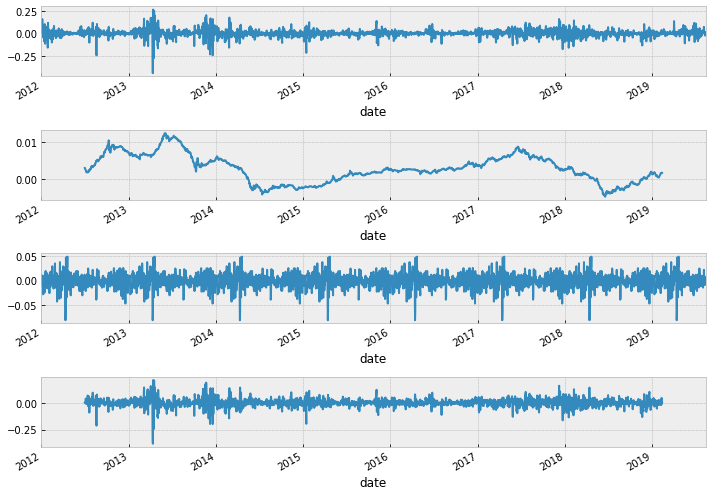

In [186]:
with plt.style.context('bmh'):

    fig = plt.figure(figsize=(10, 7))
    layout = (4, 2)
    plot1 = plt.subplot2grid(layout, (0, 0), colspan=2)
    plot2 = plt.subplot2grid(layout, (1, 0), colspan=2)
    plot3 = plt.subplot2grid(layout, (2, 0), colspan=2)
    plot4 = plt.subplot2grid(layout, (3, 0), colspan=2)
      
    
    decomposition.observed.plot(ax=plot1)
#     (decomposition.observed.mean()*daily.weighted_price[develop_mask]/daily.weighted_price[develop_mask].max()).plot(ax=plot1, color='blue')
    decomposition.trend.plot(ax=plot2)
    decomposition.seasonal.plot(ax=plot3)
    decomposition.resid.plot(ax=plot4)
    
    
    plt.tight_layout()

In [187]:
from ta import *

In [188]:
daily_df = add_all_ta_features(df=daily_df, close='close',
                              open='open', high='high', low='low', 
                               volume='sum_vol_cur', fillna=True)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ta/trend.py:170: RuntimeWarning: invalid value encountered in double_scalars
  dip[i] = 100 * (dip_mio[i]/trs[i])
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ta/trend.py:174: RuntimeWarning: invalid value encountered in double_scalars
  din[i] = 100 * (din_mio[i]/trs[i])


#### Genetic Algorithm to search for input features and Reservoir Parameters

In [ ]:
def compute_roulette(population, df, model):
    
    feats = [df.columns[i] for i in feats]
    
    input_signals = {}
    input_signals['tr'] = df[feats][train_mask][:-1]
    input_signals['val'] = daily_df[feats][val_mask][:-1]
    input_signals['te'] = daily_df[feats][test_mask][:-1]
    
    

In [163]:
import random

target_signal_tr = daily_df[train_mask]['lr_vwe_pr'][1:]
target_signal_val = daily_df[val_mask]['lr_vwe_pr'][1:]
target_signal_te = daily_df[test_mask]['lr_vwe_pr'][1:]

target_signals = {}
target_signals['tr'] = target_signal_tr
target_signals['val'] = target_signal_val
target_signals['te'] = target_signal_te

for div, signal in target_signals.items():
    target_signals[div] = signal.apply(np.std)


    
feats = [daily_df.columns[i] for i in random.sample(population=list(range(daily_df.shape[1])), k=int(daily_df.shape[1]/10)) if not daily_df[daily_df.columns[i]].isna().any() ] 

# feats= []

# Normalization of input signals
# input_signal_tr = ((daily_df[feats][train_mask]-daily_df[train_mask][feats].mean())/daily_df[train_mask][feats].std())[:-1]
# input_signal_val = ((daily_df[feats][val_mask]-daily_df[train_mask][feats].mean())/daily_df[train_mask][feats].std())[:-1]
# input_signal_te = ((daily_df[feats][test_mask]-daily_df[train_mask][feats].mean())/daily_df[train_mask][feats].std())[:-1]

# daily_df['daily_vol_cur']


input_signals = {}
input_signals['tr'] = daily_df[feats][train_mask][:-1]
input_signals['val'] = daily_df[feats][val_mask][:-1]
input_signals['te'] = daily_df[feats][test_mask][:-1]

for name, df in input_signals.items():
    df['bias'] = 1

input_signals['tr'].apply(['mean', 'std'])

,trend_mass_index,trend_vortex_ind_pos,trend_macd_signal,others_cr,momentum_wr,trend_dpo,trend_trix,bias
mean,25.155842,1.044476,12.577838,47404.546616,-41.93021,-3.043965,0.265758,1.0
std,2.648241,0.183751,262.193586,72704.260878,28.27670,292.909401,0.985540,0.0


In [174]:
feats_good = []
feats_good.append(feats)

In [176]:
feats_good[0]

['trend_mass_index',
 'trend_vortex_ind_pos',
 'trend_macd_signal',
 'others_cr',
 'momentum_wr',
 'trend_dpo',
 'trend_trix']

In [294]:
# Are the time indexes of signals correct? ( input = 1,2,3 ,... , N-1  ,  output =  2,3,4 , ... , N )

for part in ['tr', 'val', 'te']:
    
    input_signal = input_signals[part]
    target_signal = target_signals[part]
    a=set(input_signal.index).difference(set(target_signal.index))==set([input_signal.index[0]]) and set(target_signal.index).difference(set(input_signal.index))==set([target_signal.index[-1]])
    print(a)


True
True
True


## PyESN

In [17]:
# ## BEST SO FAR LOL


# import pyESN

# esn = pyESN.ESN(n_inputs = input_signals['tr'].shape[1],
#           n_outputs = 1,
#           n_reservoir = 1,
#           sparsity=0.1,
#           spectral_radius = 0.001,
#           noise=10,
#           input_scaling=True,
#           teacher_forcing=True,
#           random_state=42)


# train_preds = esn.fit(input_signals['tr'].values, target_signal_tr.values)
# print("train error: \n"+str(np.sqrt(np.mean((train_preds.flatten() - target_signal_tr.values)**2)).round(5)))

# prediction = esn.predict(inputs=input_signals['val'].values)
# print("test          \nvalid error: \n"+str(np.sqrt(np.mean((prediction.flatten() - target_signal_val.values)**2)).round(5)))
# print("y = 1 valid error: \n"+str(np.sqrt(np.mean((target_signal_val.values)**2)).round(5)))
# print("y = mean(y^tr) valid error: \n"+str(np.sqrt(np.mean((daily_df['daily_log_rets'][train_mask].mean() - target_signal_val.values)**2)).round(5)))

In [181]:
import pyESN

esn = pyESN.ESN(n_inputs = input_signals['tr'].shape[1],
          n_outputs = 1,
          n_reservoir = 20,
          sparsity=0.9,
          spectral_radius = 0.001,
          noise=0.2,
          input_scaling=True,
          teacher_forcing=True,
          random_state=42)


train_preds = esn.fit(input_signals['tr'].values, target_signal_tr.values)
print("train error: \n"+str(np.sqrt(np.mean((train_preds.flatten() - target_signal_tr.values)**2)).round(5)))

prediction = esn.predict(inputs=input_signals['val'].values)
print("test          \nvalid error: \n"+str(np.sqrt(np.mean((prediction.flatten() - target_signal_val.values)**2)).round(5)))
print("y = 1 valid error: \n"+str(np.sqrt(np.mean((target_signal_val.shift()-target_signal_val)**2)).round(5)))
print("y = mean(y^tr) valid error: \n"+str(np.sqrt(np.mean((target_signal_tr.mean() - target_signal_val.values)**2)).round(5)))

train error: 
0.04088
test          
valid error: 
0.02446
y = 1 valid error: 
0.02435
y = mean(y^tr) valid error: 
0.02052


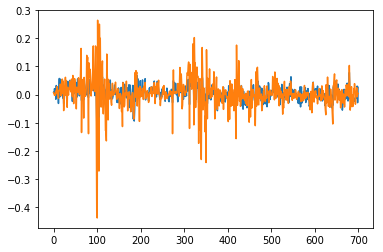

In [177]:
k=700
plt.plot(range(k), train_preds[:k])
plt.plot(range(k), target_signal_tr[:k])
# plt.plot(range(k), target_signal_val[:k].shift())

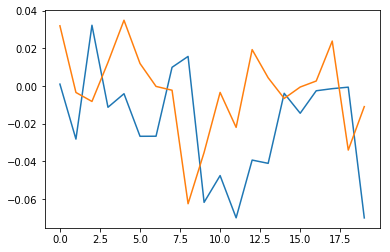

In [180]:
k=20
plt.plot(range(k), prediction[:k] )
plt.plot(range(k), target_signal_val[:k])
# plt.plot(range(k), target_signal_val[:k].shift())

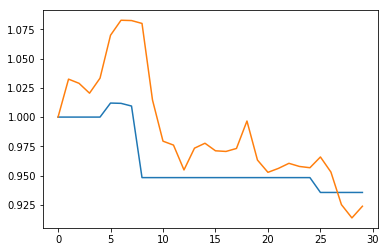

In [183]:
cum = []

states = []
states_keep = []
for i in range(len(prediction)):
    if prediction[i]>0:
        cum.append(target_signal_val[i])
    states_keep.append(np.exp(target_signal_val[:i].sum()))
    states.append(np.exp(np.sum(cum)))
        
plt.plot(range(len(states)),states)
plt.plot(range(len(states)), states_keep)


In [97]:
# from tensorflow.keras import Sequential
# from tensorflow.keras.layers import LSTM, Dense
# # define model

# n_steps = 


# model = Sequential()
# model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
# # model.add(LSTM(50, activation='relu'))
# model.add(Dense(1))
# model.compile(optimizer='adam', loss='mse')


# # model = tf.keras.Sequential()
# # model.add(tf.keras.layers.Input(input_shape=input_signal_tr.shape[1]))
# # model.add(tf.keras.layers.LSTM(50, return_sequences=True ))
# # model.add(tf.keras.layers.Dense(1, activation=None))
# # model.compile(optimizer='adam')

# input_ = input_signals['tr'].values.reshape(input_signals['tr'].values.shape[0],input_signals['tr'].values.shape[1])
# model.fit(input_, target_signals['tr'].values)

In [178]:


# plt.figure(figsize=(20,5))
# # plt.bar(range(len(target_signal_tr)+1 , len(target_signal)-1),target_signal_val,label="target system")
# plt.bar(range(len(target_signal_tr)+1 , len(target_signal)-1),prediction, label="free running ESN")
# # lo,hi = plt.ylim()
# # plt.plot([len(target_signal_tr),len(target_signal_tr)],[lo+np.spacing(1),hi-np.spacing(1)],'k:')

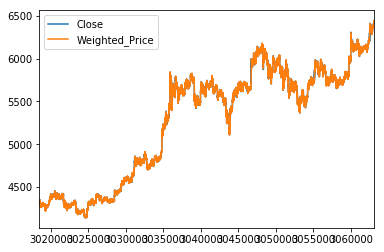

In [110]:
data[data['time_month'] == 201710][['Close', 'Weighted_Price']][:].plot()

## Targets

#### Daily returns on weighted Price

In [12]:
daily.returns = Struct()
daily.returns.we_pr = (daily.weighted_price/daily.weighted_price.shift()).apply(np.log)

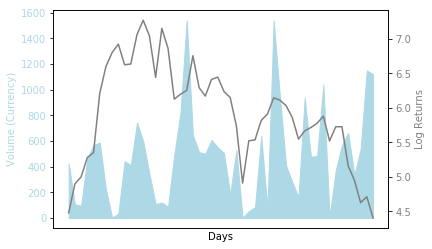

In [34]:
count = data.groupby('date')['Close'].count()

# alpha = 0.1

# daily.volume_btc.cumsum()
volume = daily.volume_cur[:50]


fig, ax1 = plt.subplots()

# Create some mock data
t = volume.index[:50]
data1 = volume.values[:50]
data2 = (daily.weighted_close.values)[:50]

ax1.set_xlabel('Days')
ax1.set_ylabel('Volume (Currency)', color='lightblue')
ax1.fill_between(t, 0, data1, color='lightblue' )
ax1.tick_params(axis='y', labelcolor='lightblue')
ax1.tick_params(axis='x', rotation=90, size=0.01)
# ax1.set_ylim(0, 500)

ax2 = ax1.twinx()


ax2.set_ylabel('Log Returns', color='grey')  # we already handled the x-label with ax1
ax2.plot(t, data2, color='grey')
ax2.tick_params(axis='y', labelcolor='grey')
# ax2.set_ylim(0, 2)


plt.xticks([x for x in volume.index if str(x)[-2:]=='01'], 
           [str(x)[:7] for x in volume.index if str(x)[-2:]=='01'])

# fig.tight_layout()  # otherwise the right y-label is slightly clipped
plt.show()

In [176]:
import pyESN

esn = pyESN.ESN(n_inputs = input_signals['tr'].shape[1],
          n_outputs = 1,
          n_reservoir = 200,
                sparsity=0.9,
          spectral_radius = 0.1,
                noise=10,
          input_scaling=True,
          teacher_forcing=True,
          random_state=42)


train_preds = esn.fit(input_signals['tr'].values, target_signal_tr.values)
print("train error: \n"+str(np.sqrt(np.mean((train_preds.flatten() - target_signal_tr.values)**2)).round(4)))

prediction = esn.predict(inputs=input_signals['val'].values)
print("test          \nvalid error: \n"+str(np.sqrt(np.mean((prediction.flatten() - target_signal_val.values)**2)).round(4)))
print("y = 0 valid error: \n"+str(np.sqrt(np.mean((target_signal_val.values)**2)).round(4)))
print("y = mean(y^tr) valid error: \n"+str(np.sqrt(np.mean((daily_df['daily_close'][train_mask].mean() - target_signal_val.values)**2)).round(4)))

print("y = y_t-1 valid error: \n"+str(np.sqrt(np.mean((daily_df['daily_close'][val_mask].shift() - target_signal_val)**2)).round(4)))


train error: 
122.1303
test          
valid error: 
6182.9864
y = 0 valid error: 
6524.8341
y = mean(y^tr) valid error: 
6304.4943
y = y_t-1 valid error: 
421.8047


In [106]:
# fix a seed for the reproducibility of results
np.random.seed(7)
  
# Be careful with memory usage
Nr = 100 # number of recurrent units
Nl = 5 # number of recurrent layers
reg = 0.0;
transient = 100
    
deepESN = DeepESN(Nu, Nr, Nl, configs)


NameError: name 'Nu' is not defined